# **Energy Consumption in the Steel Industry**

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

# =========================
# Data Loading and Cleaning
# =========================

# Data loading
df = pd.read_csv("steel_industry_data.csv")

# First visualization
print("First 5 rows of the dataframe:")
display(df.head())
print("-" * 40)
print("Dataframe information:")
display(df.info())

First 5 rows of the dataframe:


date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.28                         100.0  2700   
3                         68.09                         100.0  3600   
4                         64.72                         100.0  4500   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load  
3    Weekday      Monday  Light_Load  
4    Weekday      Monday  Light_Load

----------------------------------------
Dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type         

None

In [3]:
# Checking for null values in the dataframe
print("Null values:")
print(df.isnull().sum())
print("-" * 40)

# Checking for duplicate values in the dataframe
print("Duplicate values:")
print(df.duplicated().sum())

Null values:
date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64
----------------------------------------
Duplicate values:
0


Given that there is one column for date and another for 'NSM' (nanoseconds until midnight), only one will be used for the rest of the analysis. Therefore, the 'NSM' column will not be considered.

In [4]:
# ================
# Data Preparation
# ================

# Transforming to datetime format
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Extracting date components
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

# Deleting unnecessary columns
df = df.drop(columns=['NSM'])

# Verifying the obtained results
print("Dataframe data types:")
print(df.dtypes)
print("-" * 40)
print("First 5 rows of the prepared dataframe:")
display(df.head())

Dataframe data types:
date                                    datetime64[ns]
Usage_kWh                                      float64
Lagging_Current_Reactive.Power_kVarh           float64
Leading_Current_Reactive_Power_kVarh           float64
CO2(tCO2)                                      float64
Lagging_Current_Power_Factor                   float64
Leading_Current_Power_Factor                   float64
WeekStatus                                      object
Day_of_week                                     object
Load_Type                                       object
month                                            int32
day                                              int32
hour                                             int32
minute                                           int32
dtype: object
----------------------------------------
First 5 rows of the prepared dataframe:


date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       3.17                                  2.95   
1 2018-01-01 00:30:00       4.00                                  4.46   
2 2018-01-01 00:45:00       3.24                                  3.28   
3 2018-01-01 01:00:00       3.31                                  3.56   
4 2018-01-01 01:15:00       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor WeekStatus  \
0                         73.21                         100.0    Weekday   
1                         66.77                         100.0    Weekday   
2                         70.28                         100.0    Weekday   
3                         68.09                         100.0    Weekday   
4                         64.72                         100.0    Weekday   

  Day_of_week   Load_Type  month  day  hour  minute  
0      Monday  Light_Load      1    1     0      15  
1      Monday  Light_Load      1    1     0      30  
2      Monday  Light_Load      1    1     0      45  
3      Monday  Light_Load      1    1     1       0  
4      Monday  Light_Load      1    1     1      15

In [5]:
# ===============================
# Exploratory Data Analysis (EDA)
# ===============================

# ====================
# Categorical Analysis
# ====================

# First count for categorical variables
categorical_cols = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Order for days in 'Day_of_week'
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for colu in categorical_cols:
    print(df[colu].value_counts())
    print("-" * 30)

WeekStatus
Weekday    25056
Weekend     9984
Name: count, dtype: int64
------------------------------
Day_of_week
Monday       5088
Tuesday      4992
Wednesday    4992
Thursday     4992
Friday       4992
Saturday     4992
Sunday       4992
Name: count, dtype: int64
------------------------------
Load_Type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64
------------------------------


/tmp/ipython-input-6-2877976639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=colu, palette="pastel")
/tmp/ipython-input-6-2877976639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=colu, palette="pastel")
/tmp/ipython-input-6-2877976639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=colu, palette="pastel")


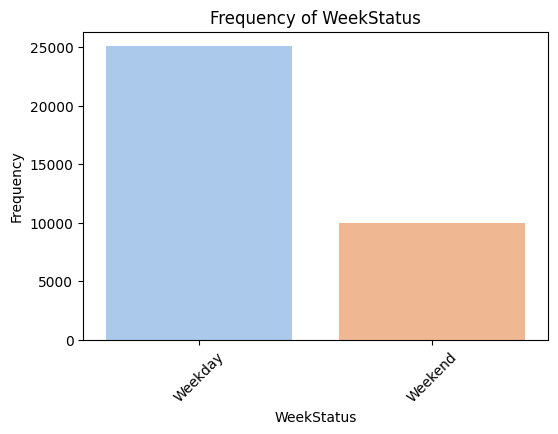

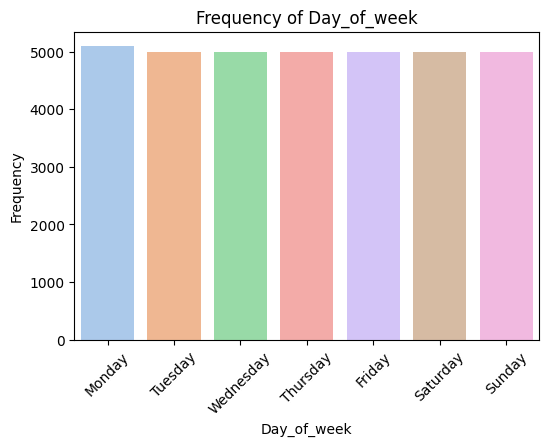

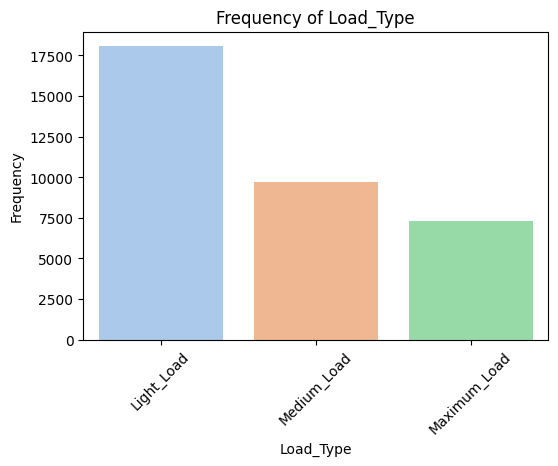

In [6]:
# Visualization for categorical variables

for colu in categorical_cols:
    plt.figure(figsize=(6, 4))
    plt.xticks(rotation=45)
    sns.countplot(data=df, x=colu, palette="pastel")
    plt.title(f'Frequency of {colu}')
    plt.ylabel('Frequency')

The values obtained for 'WeekStatus' make logical sense, as 2 days of the week are Weekend and 5 days are Weekday. The 'Load_Type' visualization shows that most of the time, the plant operates with small loads. For 'Day_of_week', the presented values also make sense. However, Monday has a higher count than the rest of the days, which could indicate an error in the data.

In [7]:
# Verification of a possible error in the dataset

counter = 0
for day in df['Day_of_week']:
    if day == 'Monday':
        counter += 1
    else:
        break

print('Data points taken per day:', counter)

Data points taken per day: 96


With the previous section completed, it can be assumed that each day has 96 data points. Therefore, the difference previously shown with more values on 'Monday' might be due to the dataset taking an extra day of data. Thus, the presence of errors in the dataset is not justified. Furthermore, the extra values for 'Monday' are small compared to the rest of the dataset, so they will not be removed for further analysis and modeling.

CO2(tCO2)
0.00    20990
0.02     4643
0.03     4261
0.04     1834
0.01     1512
0.05     1363
0.06      410
0.07       27
Name: count, dtype: int64


/tmp/ipython-input-8-3548078812.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='CO2(tCO2)', palette="pastel")


Text(0, 0.5, 'Frenquency')

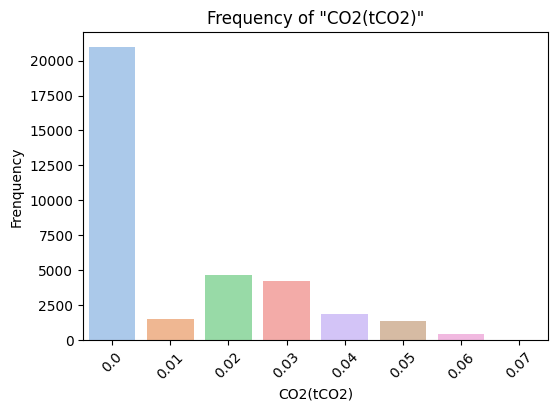

In [8]:
# ==========================================
# Univariate Analysis for Discrete Variables
# ==========================================

# Count of the 'CO2(tCO2)' variable
print(df['CO2(tCO2)'].value_counts())

# Visualization of the discrete variable
plt.figure(figsize=(6, 4))
plt.xticks(rotation=45)
sns.countplot(data=df, x='CO2(tCO2)', palette="pastel")
plt.title(f'Frequency of "CO2(tCO2)"')
plt.ylabel('Frenquency')

The distribution has a greater tendency towards the left tail, due to the plant not being in maximum operation most of the time. Therefore, it does not produce any CO2 during these periods.

In [9]:
# ================================
# Quantitative Univariate Analysis
# ================================

# First visualization of the general data
display(df.describe())

date     Usage_kWh  \
count                35040  35040.000000   
mean   2018-07-02 11:52:30     27.386892   
min    2018-01-01 00:00:00      0.000000   
25%    2018-04-02 05:56:15      3.200000   
50%    2018-07-02 11:52:30      4.570000   
75%    2018-10-01 17:48:45     51.237500   
max    2018-12-31 23:45:00    157.180000   
std                    NaN     33.444380   

       Lagging_Current_Reactive.Power_kVarh  \
count                          35040.000000   
mean                              13.035384   
min                                0.000000   
25%                                2.300000   
50%                                5.000000   
75%                               22.640000   
max                               96.910000   
std                               16.306000   

       Leading_Current_Reactive_Power_kVarh     CO2(tCO2)  \
count                          35040.000000  35040.000000   
mean                               3.870949      0.011524   
min                                0.000000      0.000000   
25%                                0.000000      0.000000   
50%                                0.000000      0.000000   
75%                                2.090000      0.020000   
max                               27.760000      0.070000   
std                                7.424463      0.016151   

       Lagging_Current_Power_Factor  Leading_Current_Power_Factor  \
count                  35040.000000                  35040.000000   
mean                      80.578056                     84.367870   
min                        0.000000                      0.000000   
25%                       63.320000                     99.700000   
50%                       87.960000                    100.000000   
75%                       99.022500                    100.000000   
max                      100.000000                    100.000000   
std                       18.921322                     30.456535   

              month           day          hour        minute  
count  35040.000000  35040.000000  35040.000000  35040.000000  
mean       6.526027     15.720548     11.500000     22.500000  
min        1.000000      1.000000      0.000000      0.000000  
25%        4.000000      8.000000      5.750000     11.250000  
50%        7.000000     16.000000     11.500000     22.500000  
75%       10.000000     23.000000     17.250000     33.750000  
max       12.000000     31.000000     23.000000     45.000000  
std        3.447901      8.796373      6.922285     16.770749

/tmp/ipython-input-10-264793371.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


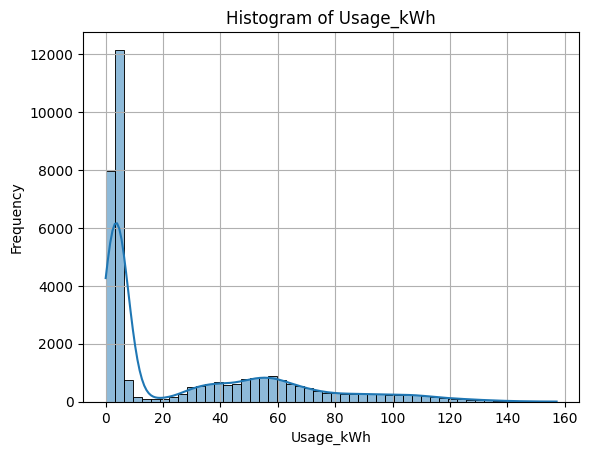

/tmp/ipython-input-10-264793371.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


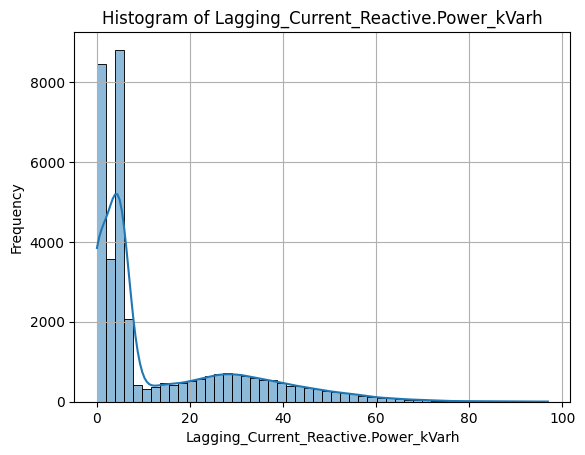

/tmp/ipython-input-10-264793371.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


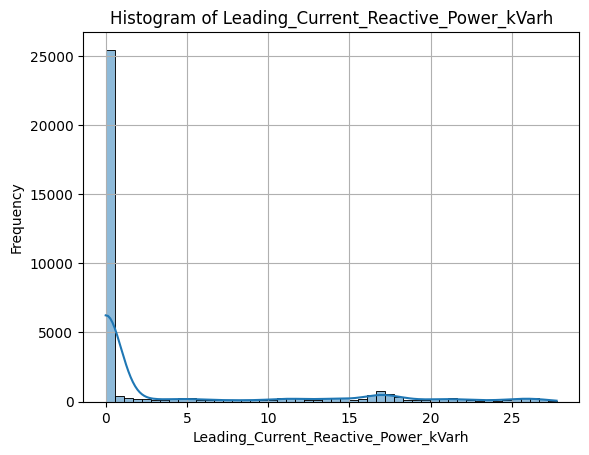

/tmp/ipython-input-10-264793371.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


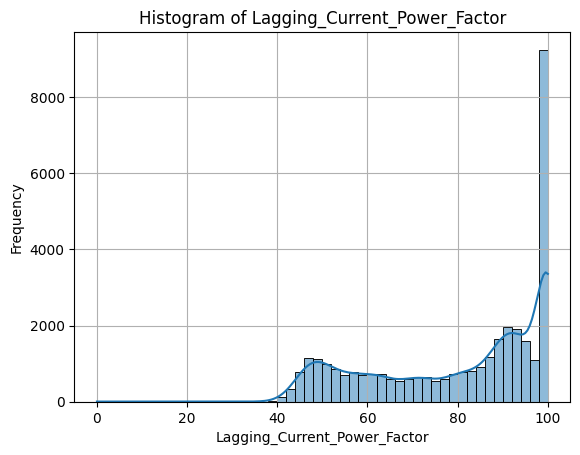

/tmp/ipython-input-10-264793371.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


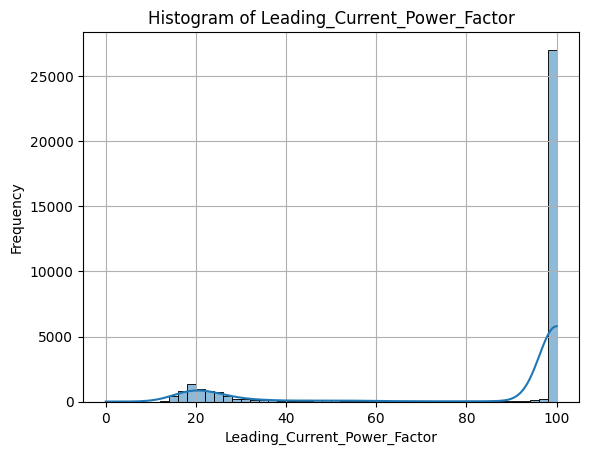

In [10]:
# Filtering only numerical columns
numerical_cols = df[['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
                'Leading_Current_Reactive_Power_kVarh',
                'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']]

# Loop to plot
for col in numerical_cols:
    sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

It is important to note that most 'Usage_KWh' values are low, but not 0. Similarly, 'Lagging_Current_Reactive.Power_kVarh' and 'Lagging_Current_Power_Factor' show a greater tendency towards the left tail, so a logarithmic transformation will be performed for both cases (to obtain a better visualization).
For 'Leading_Current_Reactive_Power_kVarh' values and consequently 'Leading_Current_Power_Factor', a strong frequency at 0 is noted, so a possible approximation would be to convert these variables to discrete, where values will be 0 or some value greater than 0.
Likewise, the graphs for the power factors are redundant for the analysis, as they depend on 'Lagging_Current_Reactive.Power_kVarh' and 'Leading_Current_Reactive_Power_kVarh', so they will not be considered for further analysis.


Leading_Current_Reactive_Power_kVarh_Bin
0    23610
1    11430
Name: count, dtype: int64


/tmp/ipython-input-11-1142911807.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Leading_Current_Reactive_Power_kVarh_Bin', palette="pastel")


Text(0, 0.5, 'Frenquency')

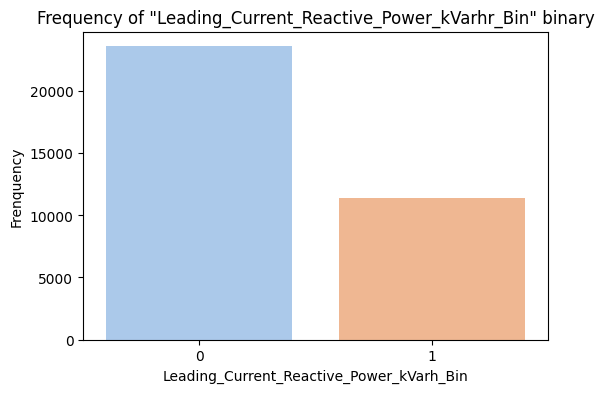

In [11]:
# Transformation of 'Leading_Current_Reactive_Power_kVarhr' to binary data
df['Leading_Current_Reactive_Power_kVarh_Bin'] = (df['Leading_Current_Reactive_Power_kVarh'] > 0).astype(int)

# Count of the 'Leading_Current_Reactive_Power_kVarhr' variable
print(df['Leading_Current_Reactive_Power_kVarh_Bin'].value_counts())

# Visualization of the discrete variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Leading_Current_Reactive_Power_kVarh_Bin', palette="pastel")
plt.title(f'Frequency of "Leading_Current_Reactive_Power_kVarhr_Bin" binary')
plt.ylabel('Frenquency')

/tmp/ipython-input-12-1619736057.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


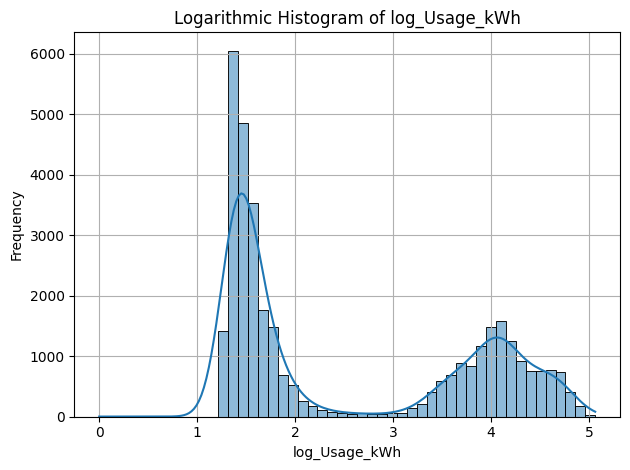

/tmp/ipython-input-12-1619736057.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


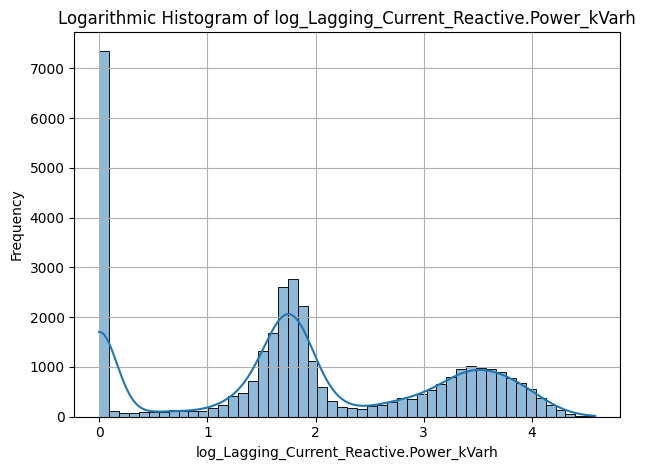

In [12]:
# Creating a log-transformed dataframe
numerical_log = df[['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh']]

for col in numerical_log:
    df[f'log_{col}'] = np.log1p(df[col])

log_cols = [col for col in df.columns if col.startswith('log_')]

# Plotting each histogram
for col in log_cols:
    sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")
    plt.title(f'Logarithmic Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Both cases present bimodal graphs, which helps in the subsequent selection of the machine learning model.

/tmp/ipython-input-13-2198302572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette="pastel")


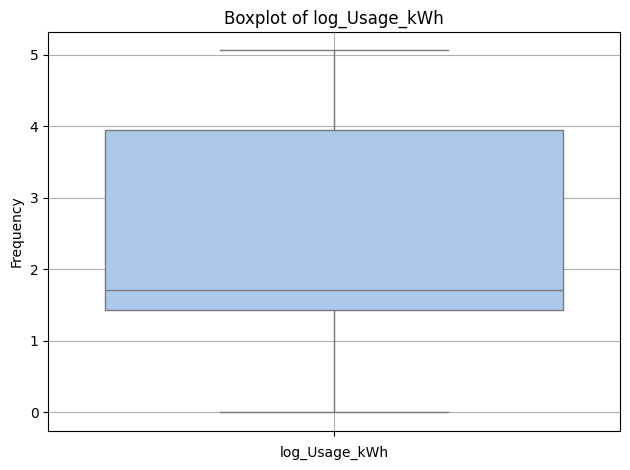

/tmp/ipython-input-13-2198302572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette="pastel")


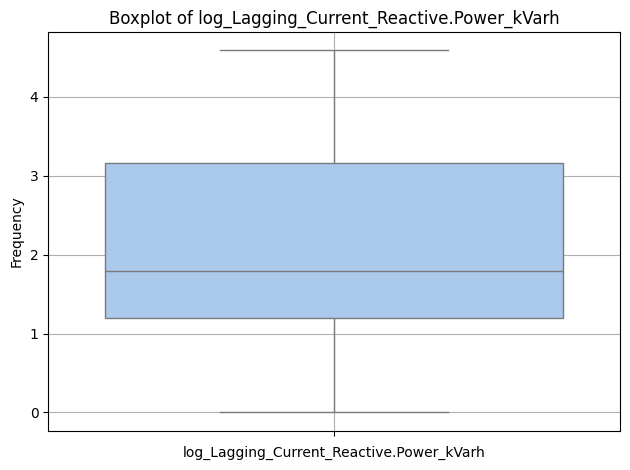

In [13]:
# Performing Boxplots for both variables

for col in log_cols:
    sns.boxplot(data=df, y=col, palette="pastel")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Both boxplots do not show outliers, so we can proceed to the analysis by grouping categorical and discrete variables.

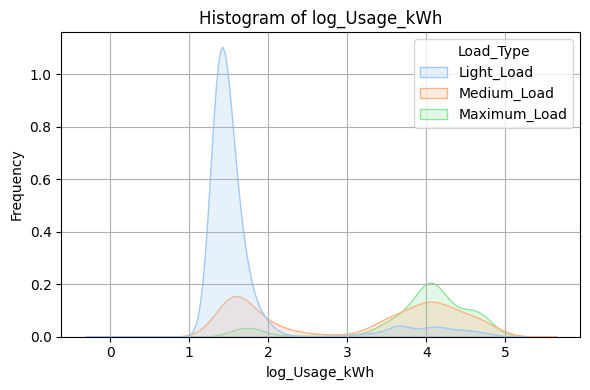

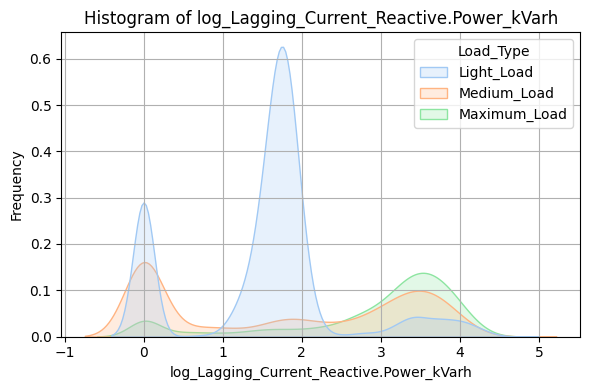

In [14]:
# Grouping by 'Load_Type'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='Load_Type', fill=True, palette="pastel")
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

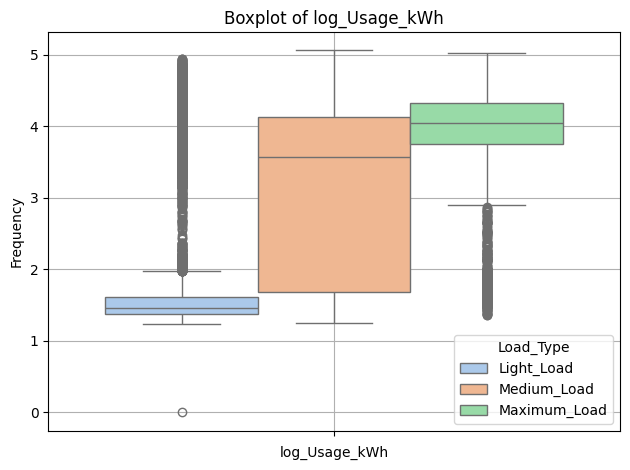

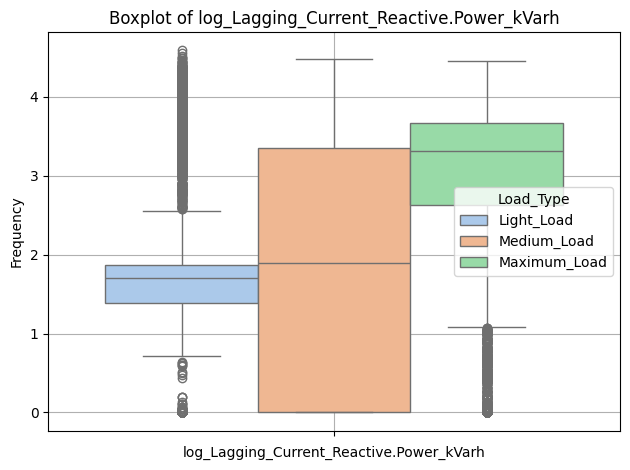

In [15]:
for col in log_cols:
    sns.boxplot(data=df, y=col, hue='Load_Type', palette="pastel")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In both cases, outliers are present for light load and maximum load, which also explains the presence of 2 modes in both variables.

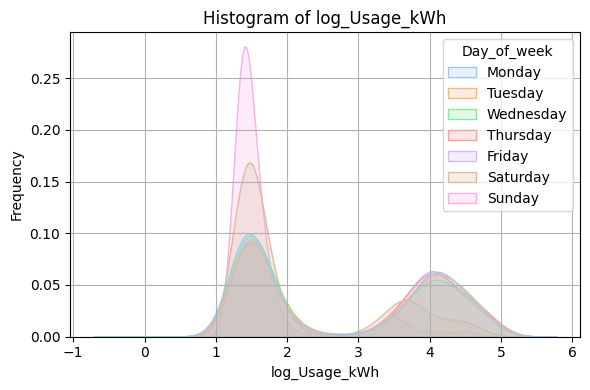

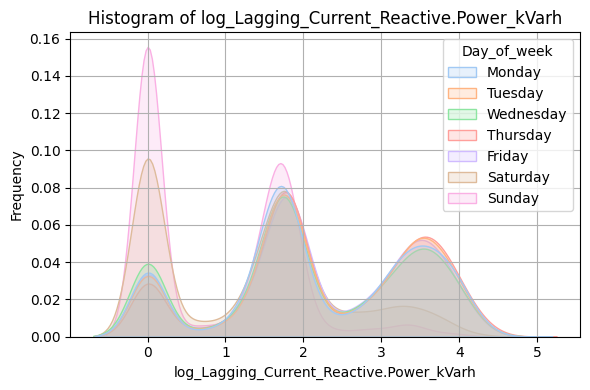

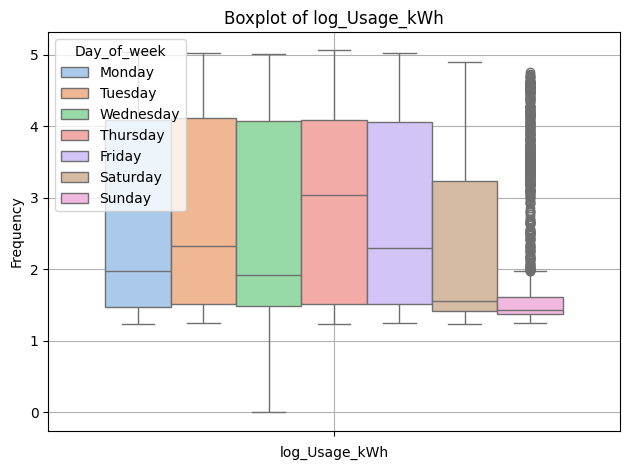

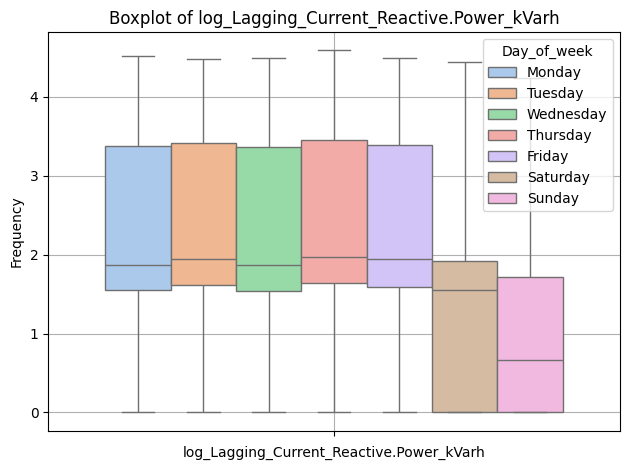

In [16]:
# Grouping by 'Day_of_week'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='Day_of_week', fill=True, palette="pastel")
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='Day_of_week', palette="pastel")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

These graphs show that on Saturdays and Sundays the plant operates less in terms of energy.

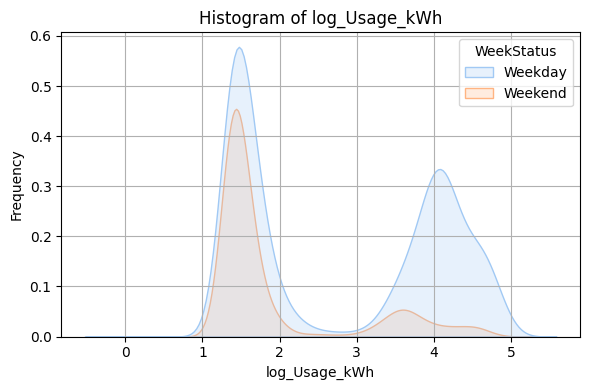

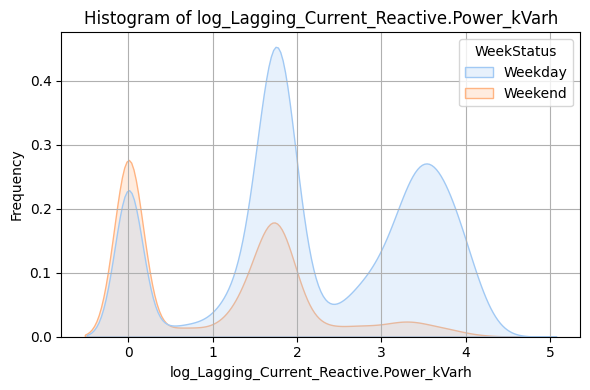

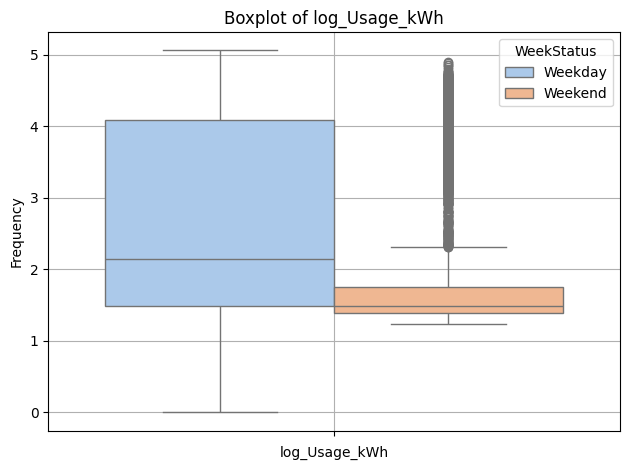

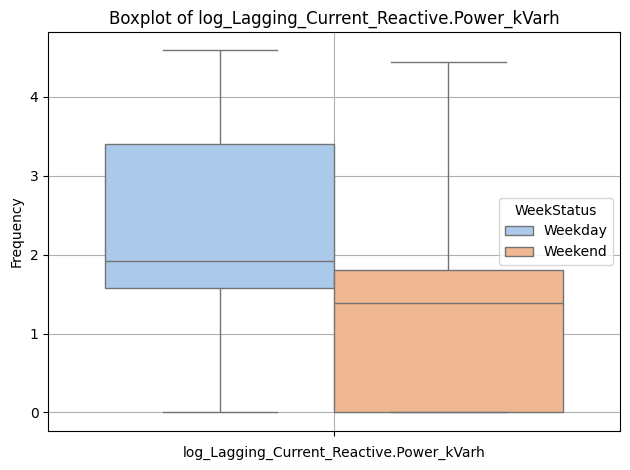

In [17]:
# Grouping by 'WeekStatus'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='WeekStatus', fill=True, palette="pastel")
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='WeekStatus', palette="pastel")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

These graphs present results similar to the previous ones. The plant's production is lower on weekends. However, it can be seen that on Sunday (the day with the lowest energy consumption) the plant does work and consumes energy like a weekday, which may indicate that it only works part of the day.

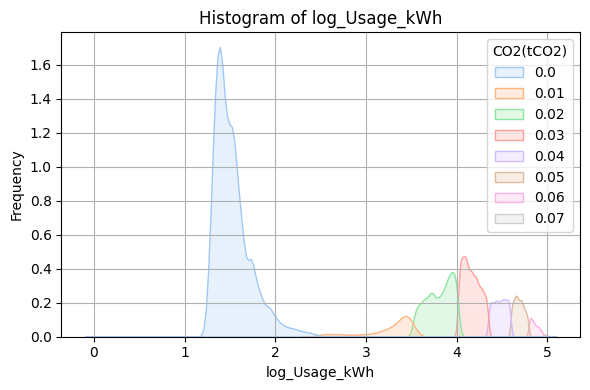

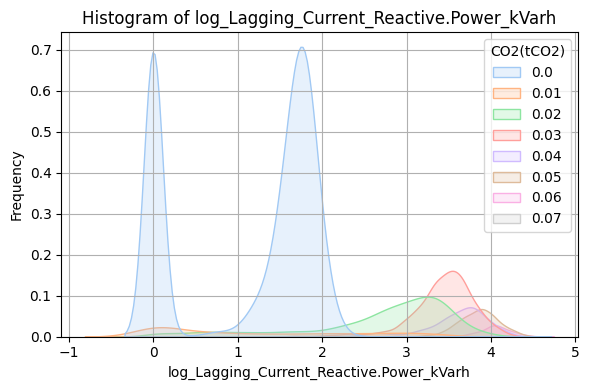

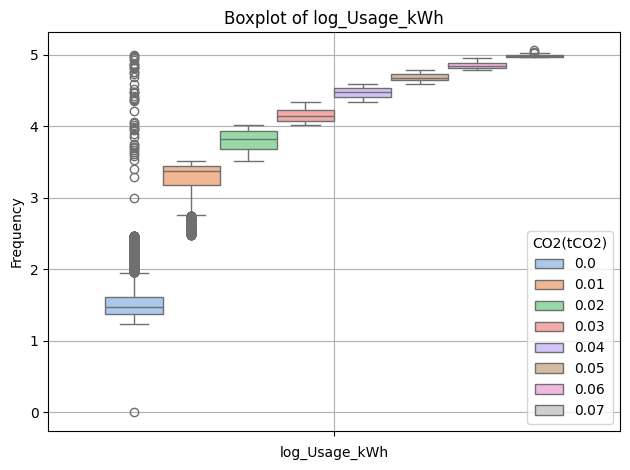

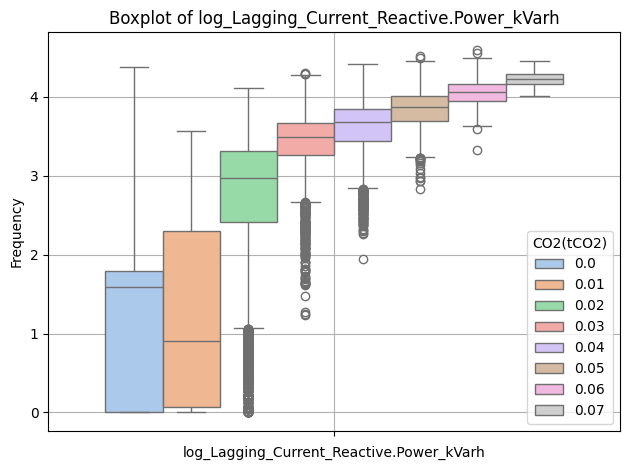

In [18]:
# Grouping by 'CO2(tCO2)'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='CO2(tCO2)', fill=True, palette="pastel")
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='CO2(tCO2)', palette="pastel")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

With these graphs, it is possible to observe how CO2 emissions increase with more plant operation. However, at the beginning of startup and non-prolonged use of the machines, they may not emit CO2, which may explain the outliers in the first case.

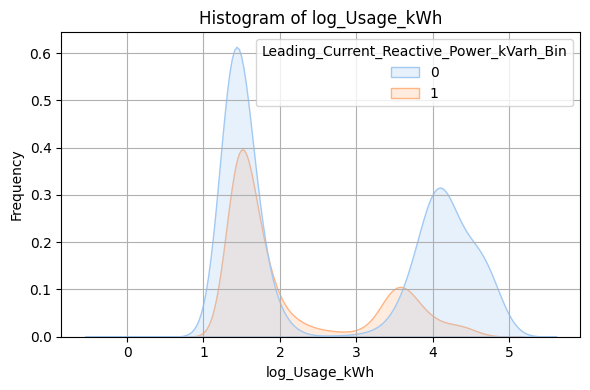

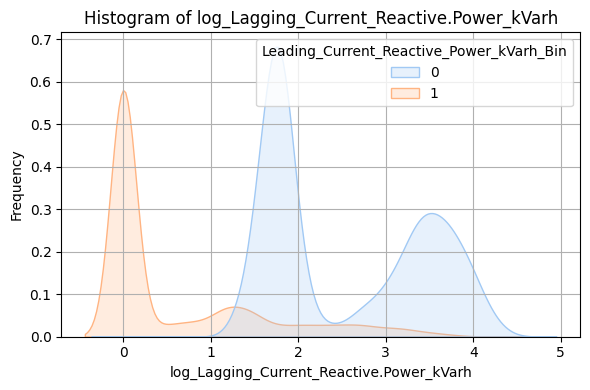

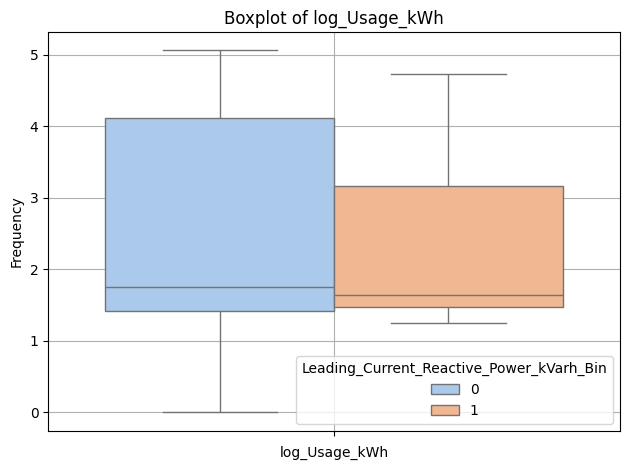

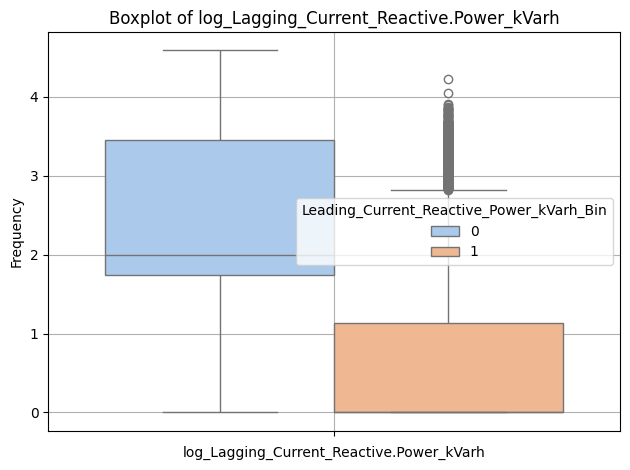

In [19]:
# Grouping by 'Leading_Current_Reactive_Power_kVarh'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='Leading_Current_Reactive_Power_kVarh_Bin', fill=True, palette="pastel")
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='Leading_Current_Reactive_Power_kVarh_Bin', palette="pastel")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In this case, the discrete variable 'Leading_Current_Reactive_Power_kVarh_Bin' well describes the movements for the target.

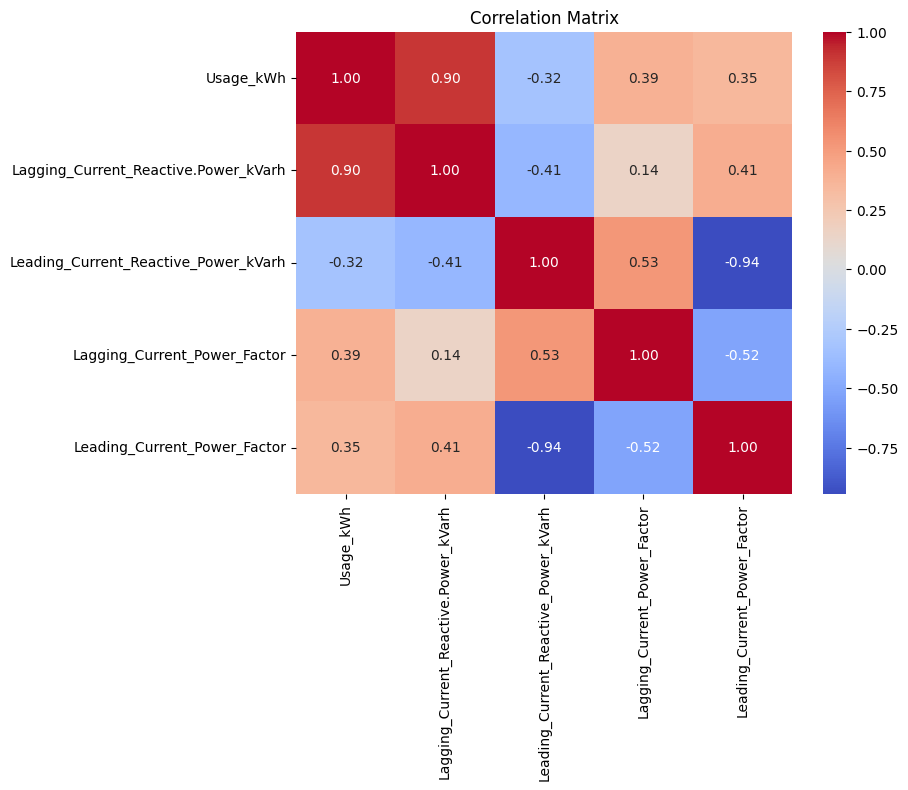

In [20]:
# ==================================
# Quantitative Multivariate Analysis
# ==================================

# Heatmap for numerical variables
matrix_df = df[['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
                'Leading_Current_Reactive_Power_kVarh',
                'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']]
plt.figure(figsize=(8,6))
sns.heatmap(matrix_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The matrix shows that the best variable to predict the target is 'Lagging_Current_Reactive_Power_kVarh'.

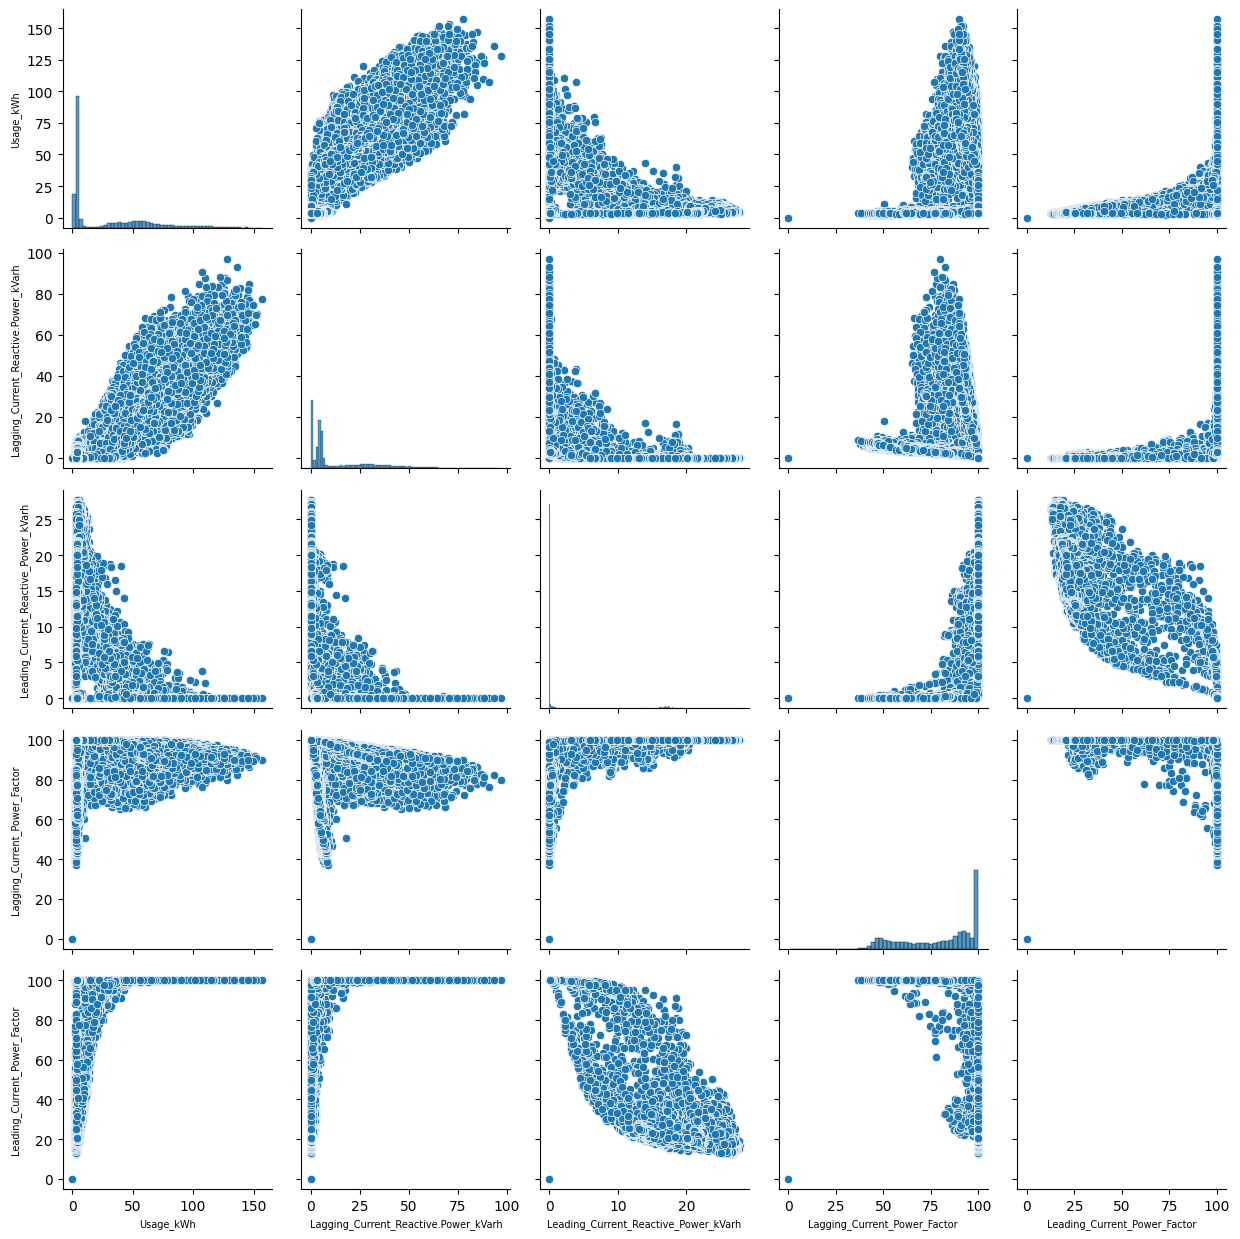

In [21]:
# Scatter plots

# Creating scatter plots for the variables
g = sns.pairplot(matrix_df)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_xlabel(ax.get_xlabel(), fontsize=7)
        ax.set_ylabel(ax.get_ylabel(), fontsize=7)

plt.tight_layout()
plt.show()

The scatter plots confirm what was previously stated.

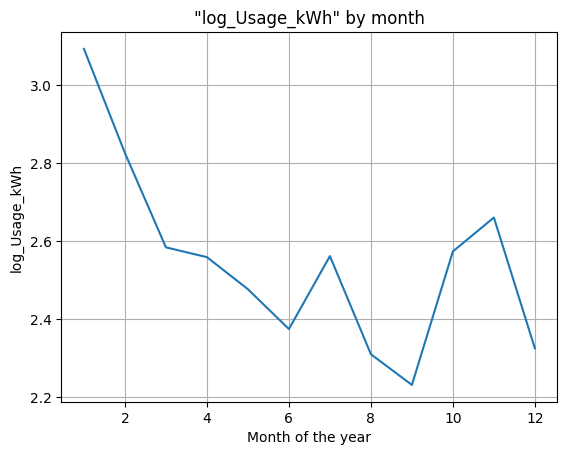

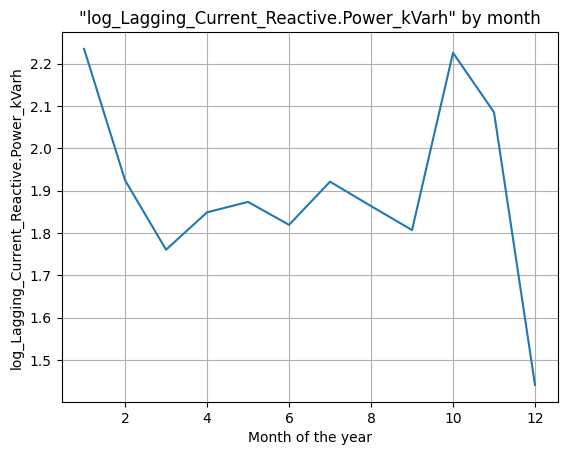

In [22]:
# ==========
# Line Plots
# ==========

# Months for 'log_Usage_KWh'
sns.lineplot(data=df, x='month', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" by month')
plt.xlabel('Month of the year')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()


# Months for 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='month', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" by month')
plt.xlabel('Month of the year')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

With both graphs, it can be observed that over a year, consumption tends to decrease until the last months of the year, where it rises again before falling. These movements may be due to the different seasons of the year for a company.

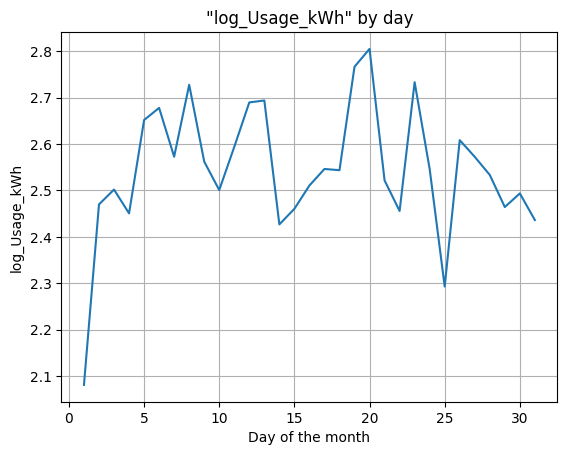

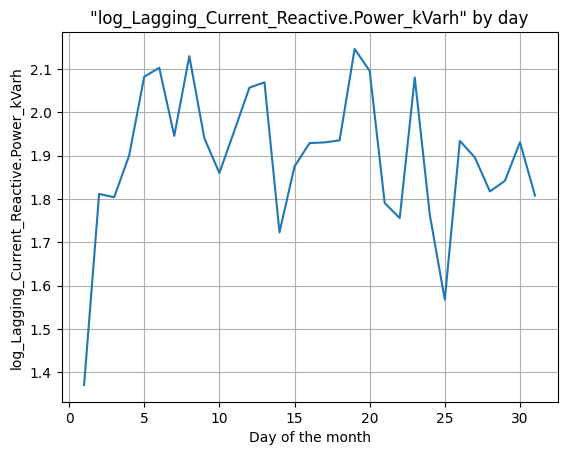

In [23]:
# Days for 'log_Usage_KWh'
sns.lineplot(data=df, x='day', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" by day')
plt.xlabel('Day of the month')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()


# Days for 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='day', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" by day')
plt.xlabel('Day of the month')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

The distribution graphs for days show a difference for the beginning and end of the month. Again, this may be due to the working methods of a company.

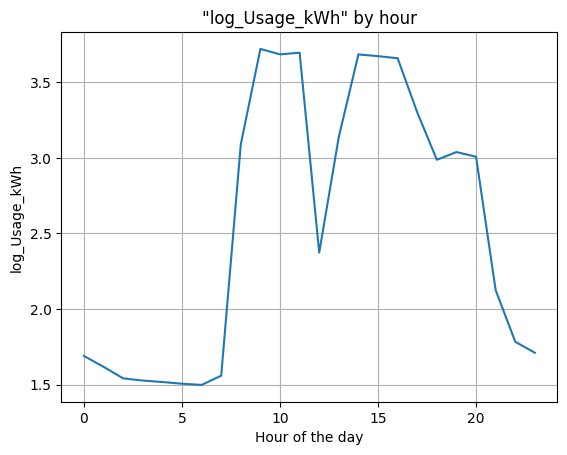

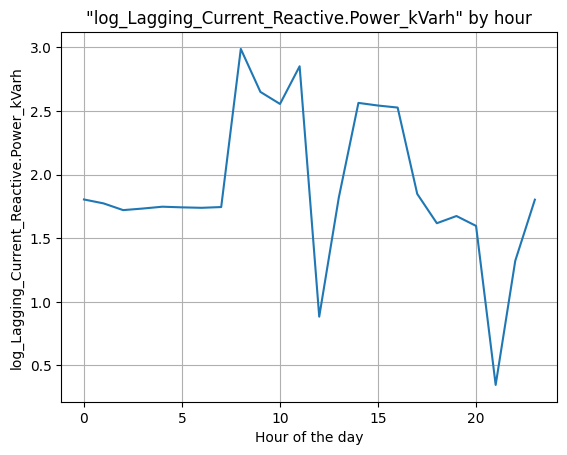

In [24]:
# Hours for 'log_Usage_KWh'
sns.lineplot(data=df, x='hour', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" by hour')
plt.xlabel('Hour of the day')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()


# Hours for 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='hour', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" by hour')
plt.xlabel('Hour of the day')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

Both graphs show a better distribution of consumption throughout the day. The working hours for the industry appear to be around 08:00 AM. This point shows the highest consumption. The lowest consumption occurs during rest hours for plant personnel (12:00 PM and at night).

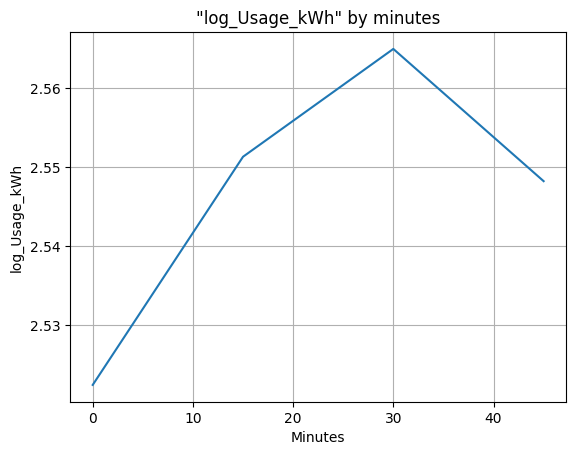

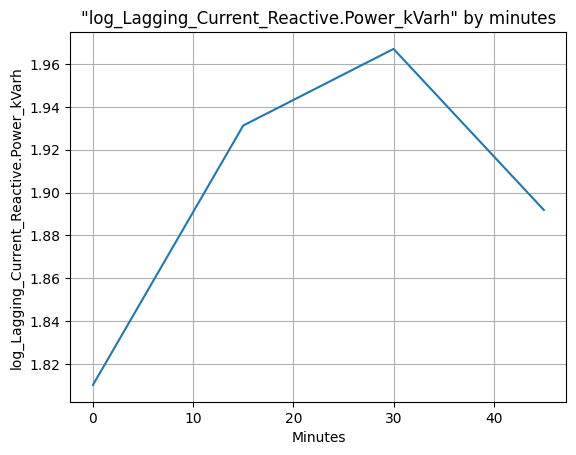

In [25]:
# Minutes for 'log_Usage_KWh'
sns.lineplot(data=df, x='minute', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" by minutes')
plt.xlabel('Minutes')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()

# Minutes for 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='minute', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" by minutes')
plt.xlabel('Minutes')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

Since the previous graphs are based on minutes, they do not provide clear information, as it was previously observed that the hours of the day show significant differences depending on the plant's operation. Therefore, minutes will not be considered in the analysis.

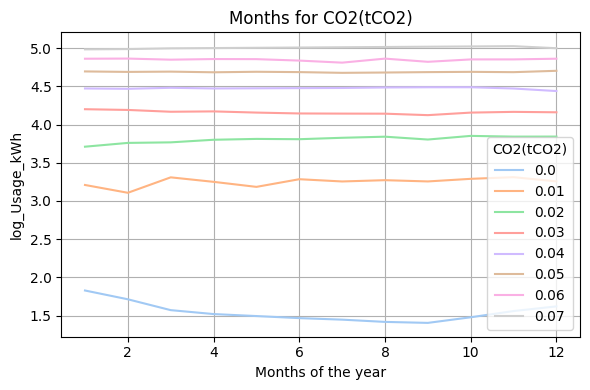

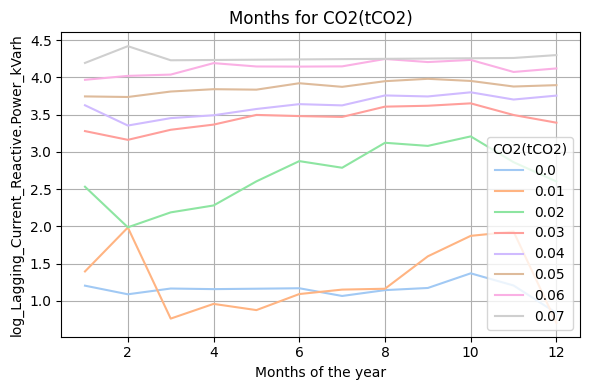

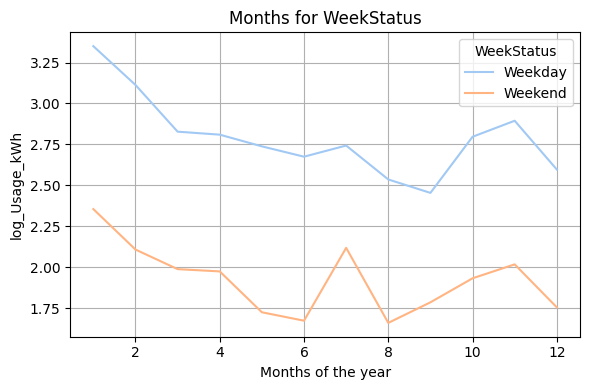

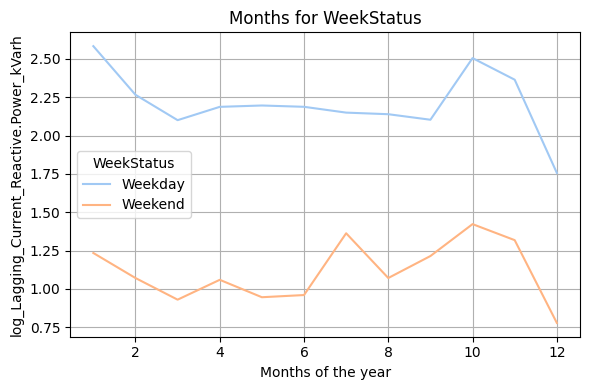

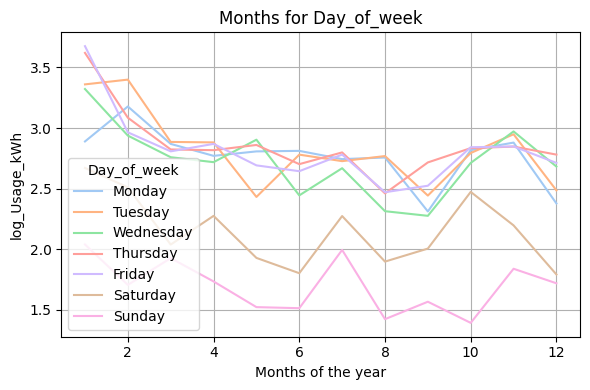

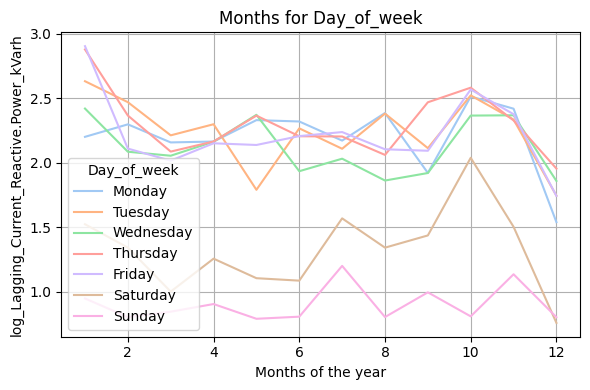

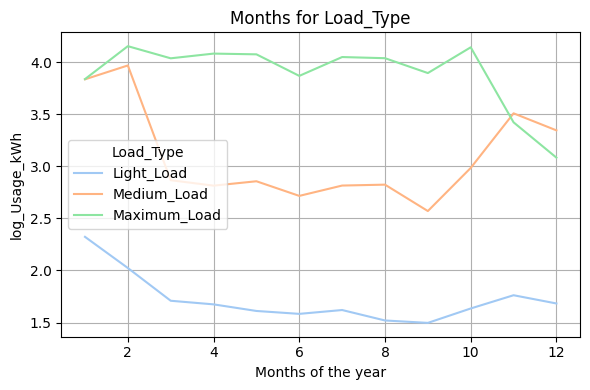

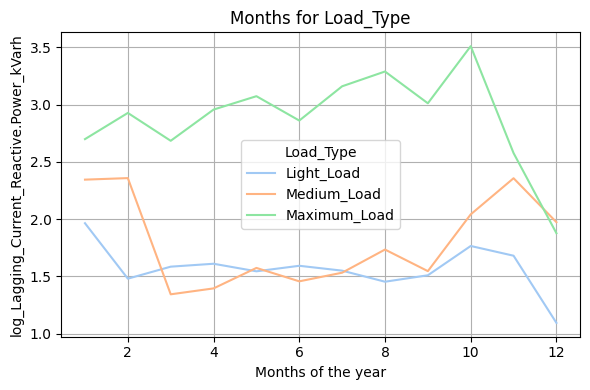

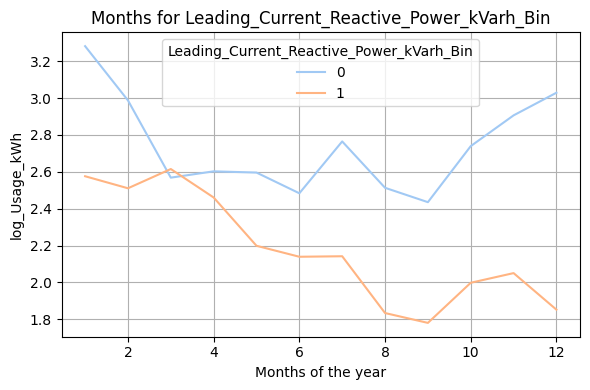

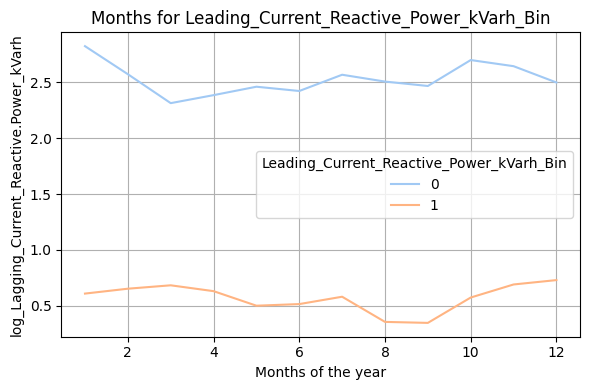

In [26]:
# Including categorical variables

col_time = df[['CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
               'Leading_Current_Reactive_Power_kVarh_Bin']]
targ_time = df[['log_Usage_kWh', 'log_Lagging_Current_Reactive.Power_kVarh']]

# Grouping by months
for col in col_time:
    for target in targ_time:
        plt.figure(figsize=(6, 4))
        sns.lineplot(data=df, x='month', y=target, hue=col, errorbar=None, palette="pastel")
        plt.title(f'Months for {col}')
        plt.xlabel('Months of the year')
        plt.ylabel(f'{target}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

The graphs grouped by 'month' confirm the results mentioned earlier in the analysis.

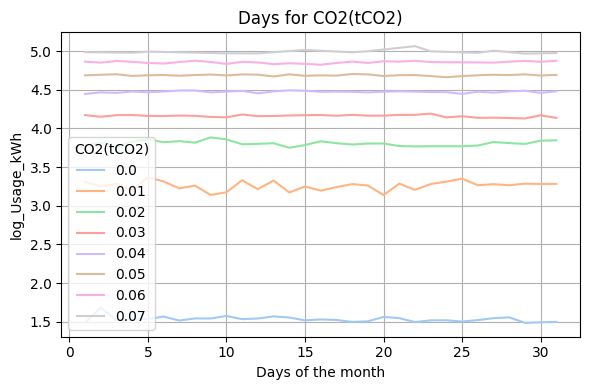

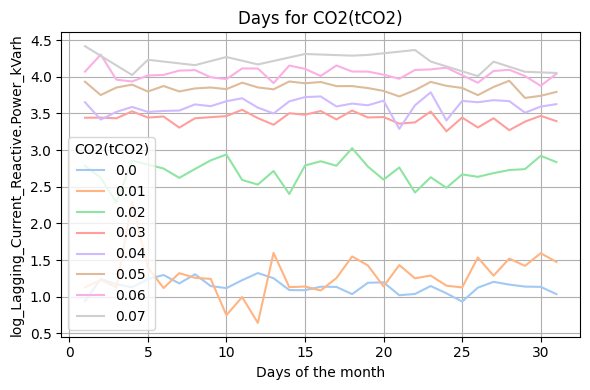

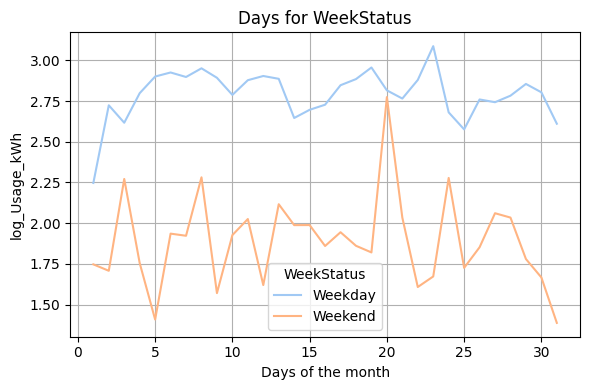

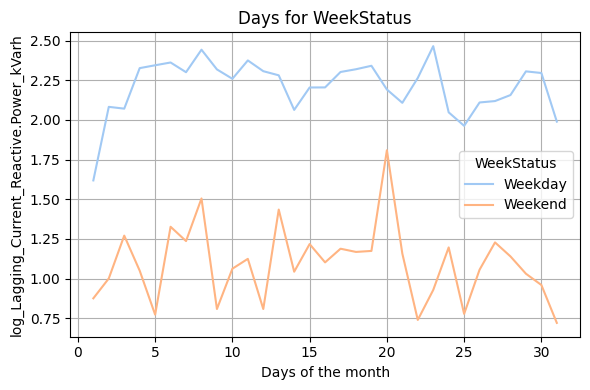

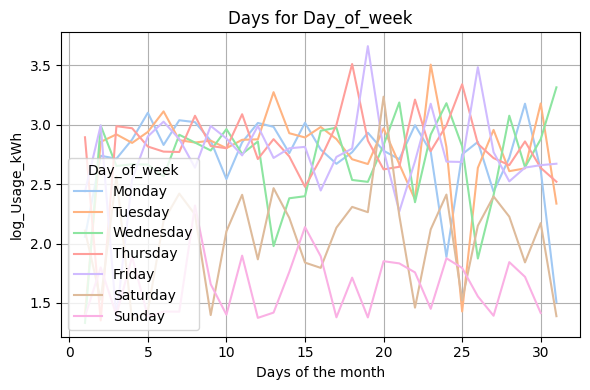

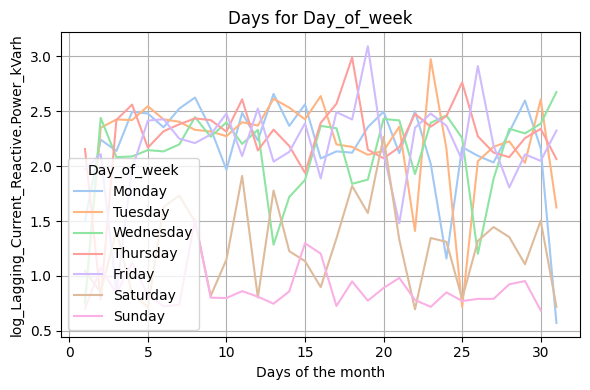

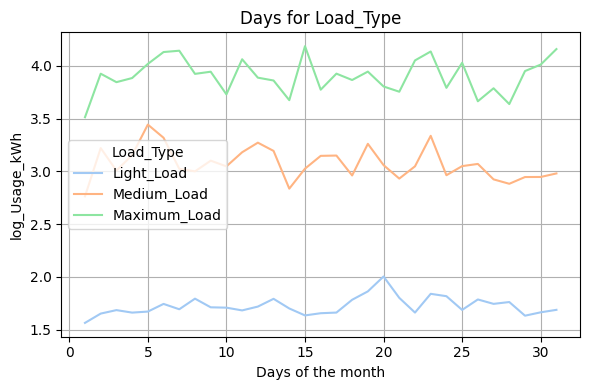

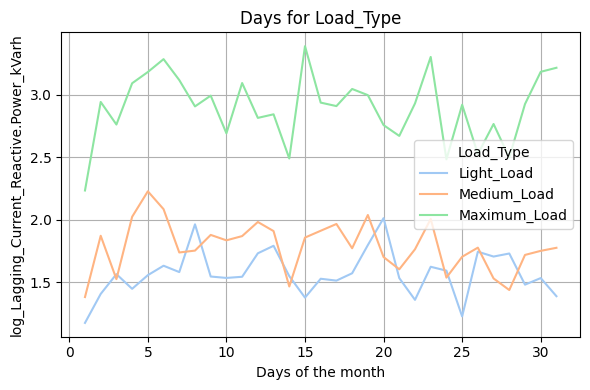

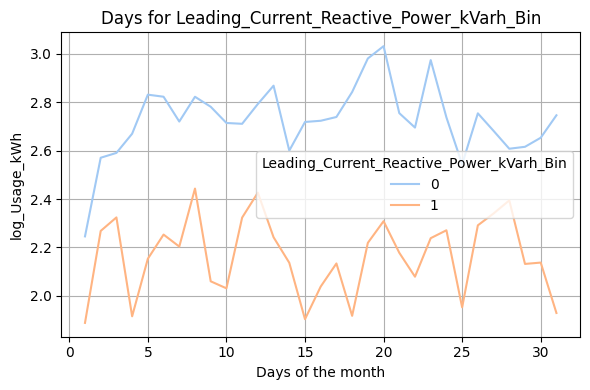

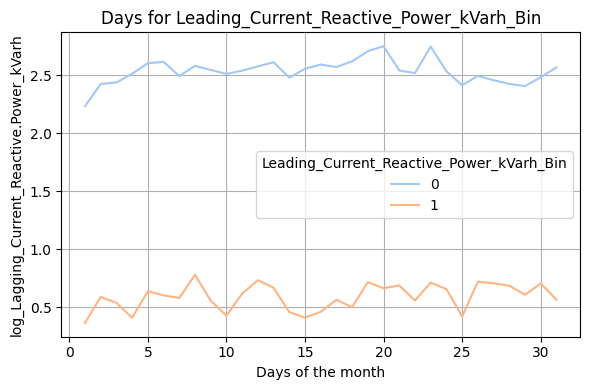

In [27]:
# Grouping by days

for col in col_time:
    for target in targ_time:
        plt.figure(figsize=(6, 4))
        sns.lineplot(data=df, x='day', y=target, hue=col, errorbar=None, palette="pastel")
        plt.title(f'Days for {col}')
        plt.xlabel('Days of the month')
        plt.ylabel(f'{target}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

The graphs grouped by 'day' confirm the results mentioned earlier in the analysis. However, it is important to note that in the 'Day_of_week' graph, the days of the week overlap because weekends vary independently of the day of the month. Nevertheless, this grouping accurately describes the results present in this analysis.

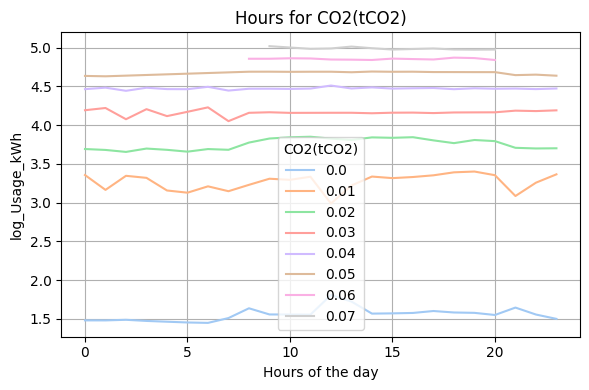

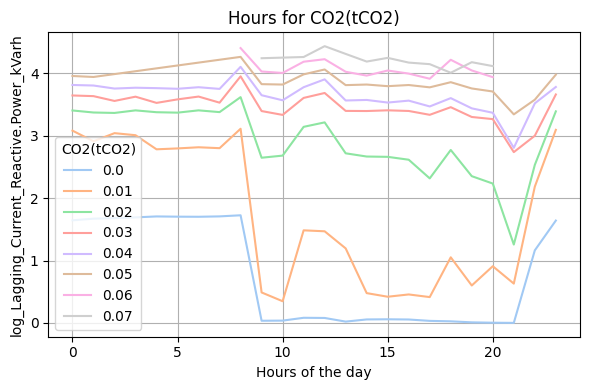

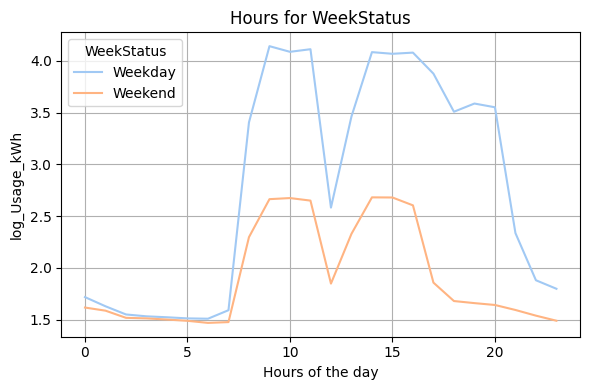

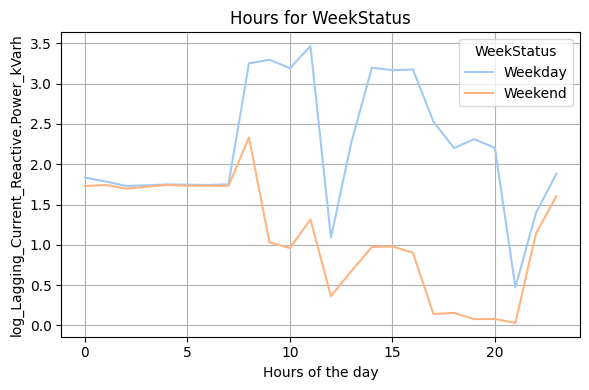

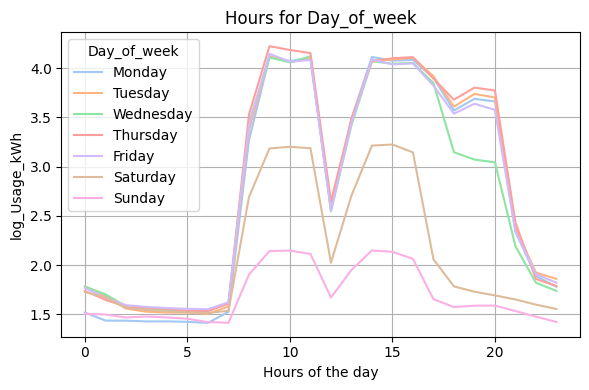

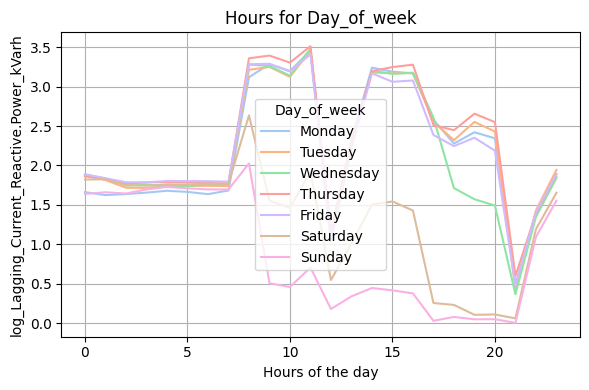

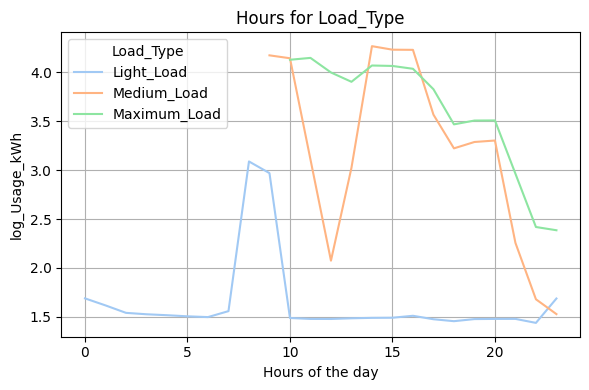

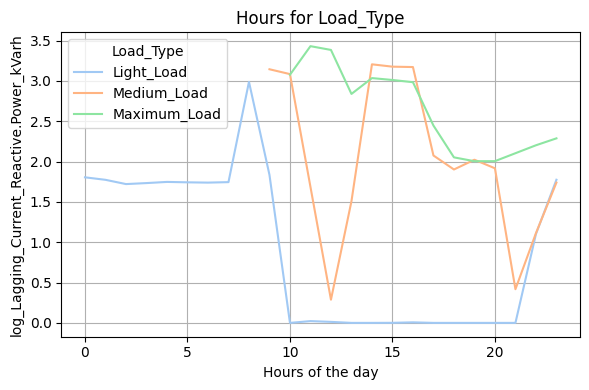

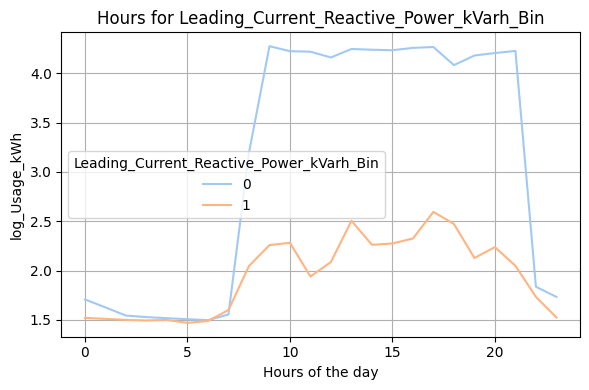

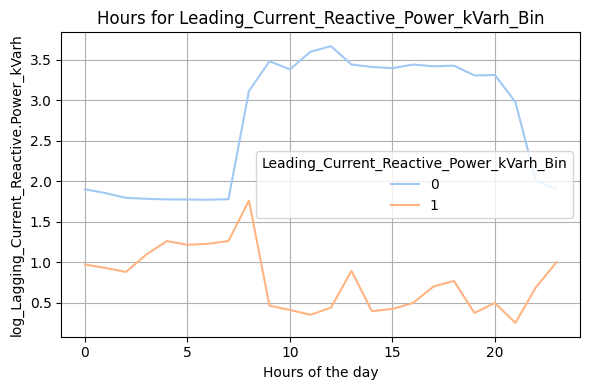

In [28]:
# Grouping by hours

for col in col_time:
    for target in targ_time:
        plt.figure(figsize=(6, 4))
        sns.lineplot(data=df, x='hour', y=target, hue=col, errorbar=None, palette="pastel")
        plt.title(f'Hours for {col}')
        plt.xlabel('Hours of the day')
        plt.ylabel(f'{target}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

With the previous graphs, a similar case is presented as in the grouping by days. In graphs like 'Day_of_week', the lines seem to overlap and not show anything in terms of response. However, these graphs still confirm the previously demonstrated results.

With all the information acquired so far, it is now possible to move on to the next point of the analysis.


In [29]:
# =================================
# Prediction using Machine Learning
# =================================

# Using the initial df for the ML model

df_ML = df[['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'WeekStatus', 'Day_of_week', 'Load_Type']]

# Creating a df for training and one for testing
X = df_ML.drop('Usage_kWh', axis=1)
y = df_ML['Usage_kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = y_train.to_frame()
y_test = y_test.to_frame()
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (24528, 7)
Shape of X_test: (10512, 7)
Shape of y_train: (24528, 1)
Shape of y_test: (10512, 1)


# ===============================
# Preprocessing for the model
# ===============================

In [30]:
# ============================
# Preprocessing for the model
# ============================

# Applying logarithms to 'Usage_kWh' and 'Lagging_Current_Reactive.Power_kVarh'
y_train['log_Usage_kWh'] = np.log1p(y_train['Usage_kWh'])
y_test['log_Usage_kWh'] = np.log1p(y_test['Usage_kWh'])
X_train['log_Lagging_Current_Reactive.Power_kVarh'] = np.log1p(X_train['Lagging_Current_Reactive.Power_kVarh'])
X_test['log_Lagging_Current_Reactive.Power_kVarh'] = np.log1p(X_test['Lagging_Current_Reactive.Power_kVarh'])

# Applying binarization to 'Leading_Current_Reactive_Power_kVarh'
X_train['Leading_Current_Reactive_Power_kVarh_Bin'] = (df['Leading_Current_Reactive_Power_kVarh'] > 0).astype(int)
X_test['Leading_Current_Reactive_Power_kVarh_Bin'] = (df['Leading_Current_Reactive_Power_kVarh'] > 0).astype(int)

# Removing columns that will not be used in the model
X_train = X_train.drop(['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh'], axis=1)
X_test = X_test.drop(['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh'], axis=1)
y_train = y_train.drop('Usage_kWh', axis=1)
y_test = y_test.drop('Usage_kWh', axis=1)

display(X_train.columns)
display(X_train.columns)

Index(['date', 'CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
       'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin'],
      dtype='object')

Index(['date', 'CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
       'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin'],
      dtype='object')

In [31]:
# Preparing temporal data in cyclic form

date = 'date'
X_train['date'] = pd.to_datetime(X_train['date'], errors='coerce')
X_test['date'] = pd.to_datetime(X_test['date'], errors='coerce')

# For X_train
X_train['month_sin'] = np.sin(2 * np.pi * X_train['date'].dt.month / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['date'].dt.month / 12)
X_train['day_sin'] = np.sin(2 * np.pi * X_train['date'].dt.dayofweek / 31) # Note: dayofweek is 0-6, not 0-30 for day of month
X_train['day_cos'] = np.cos(2 * np.pi * X_train['date'].dt.dayofweek / 31) # Note: dayofweek is 0-6, not 0-30 for day of month
X_train['hour_sin'] = np.sin(2 * np.pi * X_train['date'].dt.hour / 24)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['date'].dt.hour / 24)

# For X_test
X_test['month_sin'] = np.sin(2 * np.pi * X_test['date'].dt.month / 12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['date'].dt.month / 12)
X_test['day_sin'] = np.sin(2 * np.pi * X_test['date'].dt.dayofweek / 31) # Note: dayofweek is 0-6, not 0-30 for day of month
X_test['day_cos'] = np.cos(2 * np.pi * X_test['date'].dt.dayofweek / 31) # Note: dayofweek is 0-6, not 0-30 for day of month
X_test['hour_sin'] = np.sin(2 * np.pi * X_test['date'].dt.hour / 24)
X_test['hour_cos'] = np.cos(2 * np.pi * X_test['date'].dt.hour / 24)

# Removing columns that will not be used in the model
X_train = X_train.drop(['date'], axis=1)
X_test = X_test.drop(['date'], axis=1)

display(X_train.head())
display(X_train.columns)

CO2(tCO2) WeekStatus Day_of_week     Load_Type  \
24510       0.00    Weekday    Thursday    Light_Load   
11355       0.00    Weekend      Sunday    Light_Load   
32539       0.00    Weekday   Wednesday  Maximum_Load   
18663       0.02    Weekend    Saturday   Medium_Load   
33094       0.01    Weekday     Tuesday  Maximum_Load   

       log_Lagging_Current_Reactive.Power_kVarh  \
24510                                  1.834180   
11355                                  1.556037   
32539                                  1.650580   
18663                                  0.978326   
33094                                  0.000000   

       Leading_Current_Reactive_Power_kVarh_Bin     month_sin     month_cos  \
24510                                         0 -1.000000e+00 -1.836970e-16   
11355                                         0  8.660254e-01 -5.000000e-01   
32539                                         0 -2.449294e-16  1.000000e+00   
18663                                         1 -5.000000e-01 -8.660254e-01   
33094                                         1 -2.449294e-16  1.000000e+00   

        day_sin   day_cos  hour_sin  hour_cos  
24510  0.571268  0.820763  0.965926 -0.258819  
11355  0.937752  0.347305  0.965926 -0.258819  
32539  0.394356  0.918958 -0.258819  0.965926  
18663  0.848644  0.528964  0.500000 -0.866025  
33094  0.201299  0.979530 -0.965926 -0.258819

Index(['CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
       'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

In [32]:
# Encoding non-hierarchical categorical variables

# Categorical variables for one hot encoding
col_cat_ML = ['WeekStatus', 'Day_of_week']
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# For X_train
encoded_train_features = encoder_ohe.fit_transform(X_train[col_cat_ML])
encoded_train_df = pd.DataFrame(encoded_train_features,
                                columns=encoder_ohe.get_feature_names_out(col_cat_ML),
                                index=X_train.index)

# For X_test
encoded_test_features = encoder_ohe.transform(X_test[col_cat_ML])
encoded_test_df = pd.DataFrame(encoded_test_features,
                               columns=encoder_ohe.get_feature_names_out(col_cat_ML),
                               index=X_test.index)

X_train = pd.concat([X_train.drop(columns=col_cat_ML), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=col_cat_ML), encoded_test_df], axis=1)

display(X_train.head())
display(X_train.columns)

CO2(tCO2)     Load_Type  log_Lagging_Current_Reactive.Power_kVarh  \
24510       0.00    Light_Load                                  1.834180   
11355       0.00    Light_Load                                  1.556037   
32539       0.00  Maximum_Load                                  1.650580   
18663       0.02   Medium_Load                                  0.978326   
33094       0.01  Maximum_Load                                  0.000000   

       Leading_Current_Reactive_Power_kVarh_Bin     month_sin     month_cos  \
24510                                         0 -1.000000e+00 -1.836970e-16   
11355                                         0  8.660254e-01 -5.000000e-01   
32539                                         0 -2.449294e-16  1.000000e+00   
18663                                         1 -5.000000e-01 -8.660254e-01   
33094                                         1 -2.449294e-16  1.000000e+00   

        day_sin   day_cos  hour_sin  hour_cos  WeekStatus_Weekend  \
24510  0.571268  0.820763  0.965926 -0.258819                 0.0   
11355  0.937752  0.347305  0.965926 -0.258819                 1.0   
32539  0.394356  0.918958 -0.258819  0.965926                 0.0   
18663  0.848644  0.528964  0.500000 -0.866025                 1.0   
33094  0.201299  0.979530 -0.965926 -0.258819                 0.0   

       Day_of_week_Monday  Day_of_week_Saturday  Day_of_week_Sunday  \
24510                 0.0                   0.0                 0.0   
11355                 0.0                   0.0                 1.0   
32539                 0.0                   0.0                 0.0   
18663                 0.0                   1.0                 0.0   
33094                 0.0                   0.0                 0.0   

       Day_of_week_Thursday  Day_of_week_Tuesday  Day_of_week_Wednesday  
24510                   1.0                  0.0                    0.0  
11355                   0.0                  0.0                    0.0  
32539                   0.0                  0.0                    1.0  
18663                   0.0                  0.0                    0.0  
33094                   0.0                  1.0                    0.0

Index(['CO2(tCO2)', 'Load_Type', 'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'WeekStatus_Weekend',
       'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday'],
      dtype='object')

In [33]:
# Encoding hierarchical categorical variables

# Setting an order for OrdinalEncoder
order_Load = ['Light_Load', 'Medium_Load', 'Maximum_Load']
encoder_ordinal_singular = OrdinalEncoder(categories=[order_Load], handle_unknown='use_encoded_value',
                                          unknown_value=-1)

# For X_train
X_train['Load_Type'] = encoder_ordinal_singular.fit_transform(X_train[['Load_Type']])

# For X_test
X_test['Load_Type'] = encoder_ordinal_singular.transform(X_test[['Load_Type']])

display(X_train.head())

CO2(tCO2)  Load_Type  log_Lagging_Current_Reactive.Power_kVarh  \
24510       0.00        0.0                                  1.834180   
11355       0.00        0.0                                  1.556037   
32539       0.00        2.0                                  1.650580   
18663       0.02        1.0                                  0.978326   
33094       0.01        2.0                                  0.000000   

       Leading_Current_Reactive_Power_kVarh_Bin     month_sin     month_cos  \
24510                                         0 -1.000000e+00 -1.836970e-16   
11355                                         0  8.660254e-01 -5.000000e-01   
32539                                         0 -2.449294e-16  1.000000e+00   
18663                                         1 -5.000000e-01 -8.660254e-01   
33094                                         1 -2.449294e-16  1.000000e+00   

        day_sin   day_cos  hour_sin  hour_cos  WeekStatus_Weekend  \
24510  0.571268  0.820763  0.965926 -0.258819                 0.0   
11355  0.937752  0.347305  0.965926 -0.258819                 1.0   
32539  0.394356  0.918958 -0.258819  0.965926                 0.0   
18663  0.848644  0.528964  0.500000 -0.866025                 1.0   
33094  0.201299  0.979530 -0.965926 -0.258819                 0.0   

       Day_of_week_Monday  Day_of_week_Saturday  Day_of_week_Sunday  \
24510                 0.0                   0.0                 0.0   
11355                 0.0                   0.0                 1.0   
32539                 0.0                   0.0                 0.0   
18663                 0.0                   1.0                 0.0   
33094                 0.0                   0.0                 0.0   

       Day_of_week_Thursday  Day_of_week_Tuesday  Day_of_week_Wednesday  
24510                   1.0                  0.0                    0.0  
11355                   0.0                  0.0                    0.0  
32539                   0.0                  0.0                    1.0  
18663                   0.0                  0.0                    0.0  
33094                   0.0                  1.0                    0.0

In [34]:
# Multicollinearity

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Getting the VIF for the columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

display(vif_data.sort_values(by="VIF", ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature       VIF
7                                    day_cos       inf
16                     Day_of_week_Wednesday       inf
6                                    day_sin       inf
14                      Day_of_week_Thursday       inf
15                       Day_of_week_Tuesday       inf
13                        Day_of_week_Sunday       inf
12                      Day_of_week_Saturday       inf
11                        Day_of_week_Monday       inf
10                        WeekStatus_Weekend       inf
2   log_Lagging_Current_Reactive.Power_kVarh  8.199137
0                                  CO2(tCO2)  5.803080
3   Leading_Current_Reactive_Power_kVarh_Bin  3.686856
1                                  Load_Type  2.514743
8                                   hour_sin  2.306857
9                                   hour_cos  1.957733
4                                  month_sin  1.042582
5                                  month_cos  1.024033

There is perfect multicollinearity, therefore 'WeekStatus_Weekend' will be eliminated.

In [35]:
# Removing overrepresented variables

X_train = X_train.drop(['WeekStatus_Weekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday'], axis=1)
X_test = X_test.drop(['WeekStatus_Weekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday'], axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculating VIF for the variables
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))

                                    feature        VIF
2  log_Lagging_Current_Reactive.Power_kVarh  24.838771
7                                   day_cos  11.688140
0                                 CO2(tCO2)   8.579515
3  Leading_Current_Reactive_Power_kVarh_Bin   5.205644
1                                 Load_Type   4.352676
6                                   day_sin   3.812647
8                                  hour_sin   2.301145
9                                  hour_cos   1.951127
4                                 month_sin   1.041656
5                                 month_cos   1.023815


In [36]:
# ===============
# Model Selection
# ===============

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Coefficient of Determination (R-squared): {r2:.2f}")

Mean Squared Error (MSE): 0.10
Root Mean Squared Error (RMSE): 0.32
Coefficient of Determination (R-squared): 0.94


In [37]:
# Getting the variable names
feature_names = X_train.columns

# Getting the coefficients
coefficients = model.coef_.flatten()
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Printing the coefficients for the regression
print(coef_df)

                                    Feature  Coefficient
0                                 CO2(tCO2)    39.221552
3  Leading_Current_Reactive_Power_kVarh_Bin     0.442104
2  log_Lagging_Current_Reactive.Power_kVarh     0.407535
7                                   day_cos     0.337687
9                                  hour_cos    -0.211478
1                                 Load_Type     0.197169
8                                  hour_sin    -0.183812
6                                   day_sin     0.158925
4                                 month_sin     0.104882
5                                 month_cos     0.059204


Since CO2 emissions are determined by plant operation, it would be correct to remove this column as a predictor variable to have a different analysis.

In [38]:
X_train = X_train.drop(['CO2(tCO2)'], axis=1)
X_test = X_test.drop(['CO2(tCO2)'], axis=1)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Coefficient of Determination (R-squared): {r2:.2f}")

Mean Squared Error (MSE): 0.17
Root Mean Squared Error (RMSE): 0.41
Coefficient of Determination (R-squared): 0.90


In [39]:
# Getting the feature names
feature_names = X_train.columns

# Getting the coefficients
coefficients = model.coef_.flatten()
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Displaying the regression coefficients
print(coef_df)

                                    Feature  Coefficient
1  log_Lagging_Current_Reactive.Power_kVarh     0.845461
2  Leading_Current_Reactive_Power_kVarh_Bin     0.764118
8                                  hour_cos    -0.391340
7                                  hour_sin    -0.374134
6                                   day_cos     0.298938
0                                 Load_Type     0.245746
3                                 month_sin     0.180039
5                                   day_sin     0.133756
4                                 month_cos     0.079152


This approach seems more realistic, with less overfitting and better interpretability. As observed earlier in the EDA, 'log_lagging_Current_Reactive.Power_kVarh' is the variable that has the most influence on consumption. Likewise, 'Leading_Current_Reactive_Power_kVarh_Bin' has a significant influence on the model. On the other hand, for the other variables, the influence is minor but still needs to be taken into account.

## Conclusions

With this project, a linear regression model was successfully developed to efficiently describe the energy consumption 'Usage_kWh' for a steel industry plant. The analysis was conducted using operational and temporal data from the plant.

The model's efficiency is mainly attributed to the data preprocessing stage and a proper exploratory data analysis (EDA). Different properties of the dataset were identified, such as the lack of a normal distribution for the target variable and multicollinearity among operational variables. The application of logarithms and various transformations to the variables were crucial for reaching important conclusions during the EDA. Additionally, the EDA helped to understand the plant’s operation based on temporal variables.

For the prediction model, it was important to check for perfect multicollinearity between variables. After this assessment, variables that would not be useful for the prediction model were strategically removed, as some were repetitive.

The decision to exclude the variable 'CO2(tCO2)' as a predictor, despite its high correlation with consumption, was an important choice to improve the model’s interpretability and to avoid predicting a byproduct of consumption (CO2 emissions). This approach strengthens the model’s usefulness by focusing on operational factors that can be controlled or monitored to influence consumption.

The analysis of the model coefficients revealed that 'log_Lagging_Current_Reactive.Power_kVarh' is the most influential predictor of energy consumption, which aligns with initial EDA observations indicating a strong correlation. The variable 'Leading_Current_Reactive_Power_kVarh_Bin' also proved to be a significant factor. Other temporal and operational variables, such as cyclical components of hour and month, and 'Load_Type', also contribute importantly to the prediction.

Finally, the regression model showed high performance in predicting consumption for the data. The R value is close to 1, indicating that the model accurately represents the patterns present in the plant’s data.